In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install tensorflow keras numpy pandas matplotlib

# Import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Mounted at /content/drive


Load and Prepare Jena Weather Data

In [ ]:
# Download the dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile

# Correct URL with .zip extension
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file("jena_climate_2009_2016.csv.zip", url)

# Extract the zip file
with ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall()

# Load the CSV data
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)

# Display basic information
print(f"Data shape: {df.shape}")
print("First 5 rows:")
display(df.head())

# Convert to numpy array - EXCLUDING the date column
# The first column is the date/time which is causing the error
date_time = df.iloc[:, 0]  # Save for reference if needed
numeric_data = df.iloc[:, 1:].values  # Only numeric columns

# Normalize the data
mean = numeric_data[:200000].mean(axis=0)
std = numeric_data[:200000].std(axis=0)
normalized_data = (numeric_data - mean) / std

# Set parameters
sampling_rate = 6  # One data point per hour
sequence_length = 120  # Using 5 days of data (120 hours) for each sample
delay = sampling_rate * (sequence_length + 24 - 1)  # Target is 24 hours in future
batch_size = 256

# Extract temperature column (target for prediction)
temperature = normalized_data[:, 0]  # Temperature is the first column after removing date

print(f"\nData preparation complete:")
print(f"- Total samples: {len(numeric_data)}")
print(f"- Sampling rate: {sampling_rate} (1 sample per hour)")
print(f"- Sequence length: {sequence_length} hours (5 days)")
print(f"- Prediction target: Temperature 24 hours in the future")




Data shape: (420551, 15)
First 5 rows:


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3



Data preparation complete:
- Total samples: 420551
- Sampling rate: 6 (1 sample per hour)
- Sequence length: 120 hours (5 days)
- Prediction target: Temperature 24 hours in the future


Create Time Series Datasets

In [ ]:
# Import TensorFlow if not already imported
import tensorflow as tf
from tensorflow import keras

# Define the function to create datasets
def create_dataset(data, start_index, end_index):
    return keras.preprocessing.timeseries_dataset_from_array(
        data[:-delay],
        targets=temperature[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=start_index,
        end_index=end_index
    )

# Define the number of samples for training, validation, and testing
num_train_samples = int(0.6 * len(normalized_data))
num_val_samples = int(0.2 * len(normalized_data))

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")


# Create the three datasets
print("Creating time series datasets...")
train_dataset = create_dataset(normalized_data, 0, num_train_samples)
val_dataset = create_dataset(normalized_data, num_train_samples, num_train_samples + num_val_samples)
test_dataset = create_dataset(normalized_data, num_train_samples + num_val_samples, None)

# Check the structure of the datasets
for features_batch, targets_batch in train_dataset.take(1):
    print(f"Features batch shape: {features_batch.shape}")
    print(f"Targets batch shape: {targets_batch.shape}")

print("\nDatasets created successfully:")
print(f"- Training samples: {num_train_samples}")
print(f"- Validation samples: {num_val_samples}")
print(f"- Test samples: {len(normalized_data) - (num_train_samples + num_val_samples)}")


Number of training samples: 252330
Number of validation samples: 84110
Creating time series datasets...
Features batch shape: (256, 120, 14)
Targets batch shape: (256,)

Datasets created successfully:
- Training samples: 252330
- Validation samples: 84110
- Test samples: 84111


Build Baseline LSTM Model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │           6,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,049 (23.63 KB)

 Trainable params: 6,049 (23.63 KB)

 Non-trainable params: 0 (0.00 B)

Training baseline LSTM model...
Epoch 1/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 198s 197ms/step - loss: 0.5085 - mae: 0.5463 - val_loss: 0.4577 - val_mae: 0.5169
Epoch 2/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 196s 199ms/step - loss: 0.4231 - mae: 0.4953 - val_loss: 0.4430 - val_mae: 0.5059
Epoch 3/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 196s 199ms/step - loss: 0.4061 - mae: 0.4842 - val_loss: 0.4438 - val_mae: 0.5052
Epoch 4/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 195s 198ms/step - loss: 0.3963 - mae: 0.4784 - val_loss: 0.4449 - val_mae: 0.5020
Epoch 5/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 196s 199ms/step - loss: 0.3865 - mae: 0.4721 - val_loss: 0.4492 - val_mae: 0.5035
Epoch 6/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 204s 201ms/step - loss: 0.3791 - mae: 0.4683 - val_loss: 0.4514 - val_mae: 0.5055
Epoch 7/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 196s 199ms/step - loss: 0.3766 - mae: 0.4667 - val_loss: 0.4558 - val_mae: 0.5085
Epoch 8/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 196s 199ms/step - loss: 0.3697 - mae: 0.4636 - val_loss: 0.4495 - val_mae:

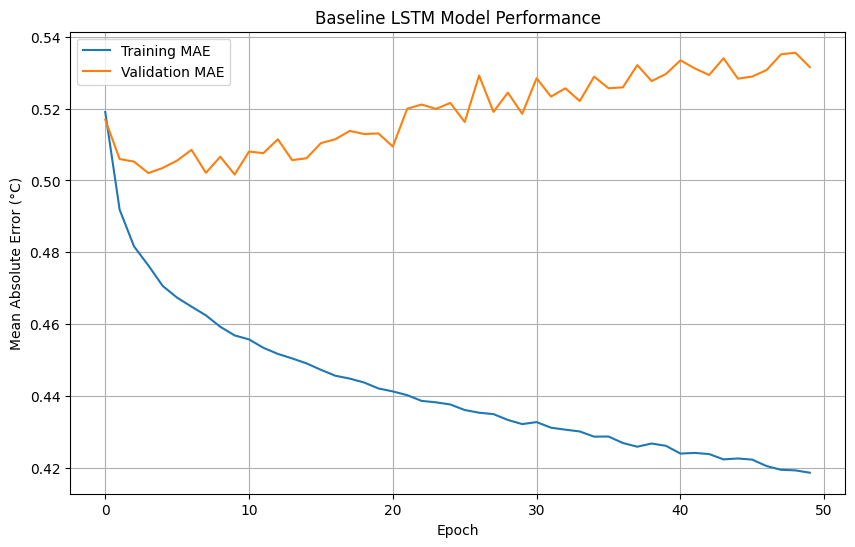

In [ ]:
# Import required packages
from tensorflow import keras
from tensorflow.keras import layers

# Define baseline LSTM model
def build_baseline_lstm():
    inputs = keras.Input(shape=(sequence_length, normalized_data.shape[-1]))
    x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

# Create model instance
baseline_model = build_baseline_lstm()
baseline_model.summary()

# Set up checkpoint callback to save best model
checkpoint_path = "/content/drive/MyDrive/models/baseline_lstm.keras"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True
)

# Train the model
print("Training baseline LSTM model...")
history = baseline_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)

# Load best model and evaluate on test set
best_model = keras.models.load_model(checkpoint_path)
test_mae = best_model.evaluate(test_dataset)[1]
print(f"Baseline LSTM Test MAE: {test_mae:.4f}")

# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Baseline LSTM Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (°C)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/baseline_lstm_performance.png')
plt.show()


In [7]:
# Import required libraries if not already imported
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

# Define normalized_data_shape explicitly
normalized_data_shape = 14  # Number of features after removing date column

# Function to evaluate models with early stopping
def evaluate_model(model_name, model_fn):
    print(f"\n===== Training {model_name} =====")

    # Build model
    model = model_fn()
    model.summary()

    # Set up checkpoint and early stopping
    checkpoint_path = f"/content/drive/MyDrive/models/{model_name.lower().replace(' ', '_')}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    ]

    # Train model with fewer epochs
    history = model.fit(
        train_dataset,
        epochs=15,  # Reduced epochs based on baseline overfitting
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Evaluate on test set
    test_mae = model.evaluate(test_dataset)[1]
    print(f"{model_name} Test MAE: {test_mae:.4f}")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{model_name} Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (°C)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/{model_name.lower().replace(" ", "_")}_performance.png')
    plt.show()

    return history, test_mae


Implement Larger LSTM model


===== Training Larger LSTM =====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 309s 308ms/step - loss: 0.4889 - mae: 0.5344 - val_loss: 0.4540 - val_mae: 0.5091
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 316s 302ms/step - loss: 0.3926 - mae: 0.4765 - val_loss: 0.4543 - val_mae: 0.5033
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 298s 303ms/step - loss: 0.3716 - mae: 0.4629 - val_loss: 0.4565 - val_mae: 0.5025
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 299s 303ms/step - loss: 0.3567 - mae: 0.4549 - val_loss: 0.4666 - val_mae: 0.5064
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 300s 305ms/step - loss: 0.3418 - mae: 0.4461 - val_loss: 0.4721 - val_mae: 0.5099
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 327s 311ms/step - loss: 0.3309 - mae: 0.4390 - val_loss: 0.4836 - val_mae: 0.5148
Epoch 7/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 316s 305ms/step - loss: 0.3177 - mae: 0.4311 - val_loss: 0.4897 - val_mae: 0.5175
Epoch 8/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 298s 303ms/step - loss: 0.3068 - mae: 0.4249 - val_loss: 0.4924 - val_mae: 0.5176
323/323 ━━━━━━━━━━━━━━━━

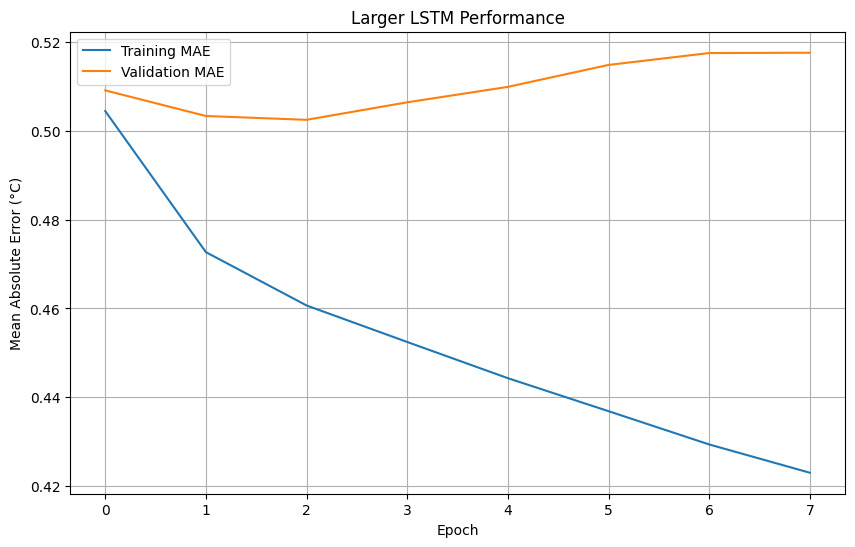

In [8]:
# 1. Larger LSTM model with 64 units
def build_larger_lstm():
    inputs = keras.Input(shape=(sequence_length, normalized_data_shape))
    x = layers.LSTM(64, recurrent_dropout=0.25)(inputs)  # Increased from 32 to 64 units
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

# Train the larger LSTM model
hist_larger, mae_larger = evaluate_model("Larger LSTM", build_larger_lstm)



===== Training Stacked LSTM =====


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 120, 64)             │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 530s 533ms/step - loss: 0.4848 - mae: 0.5329 - val_loss: 0.4762 - val_mae: 0.5187
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 503s 511ms/step - loss: 0.3854 - mae: 0.4731 - val_loss: 0.5031 - val_mae: 0.5314
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 769s 782ms/step - loss: 0.3415 - mae: 0.4473 - val_loss: 0.5390 - val_mae: 0.5439
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 534s 543ms/step - loss: 0.3009 - mae: 0.4209 - val_loss: 0.5776 - val_mae: 0.5565
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 692s 703ms/step - loss: 0.2652 - mae: 0.3968 - val_loss: 0.6295 - val_mae: 0.5808
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 579s 589ms/step - loss: 0.2363 - mae: 0.3761 - val_loss: 0.6590 - val_mae: 0.5933
323/323 ━━━━━━━━━━━━━━━━━━━━ 51s 158ms/step - loss: 0.3549 - mae: 0.4610
Stacked LSTM Test MAE: 0.4597


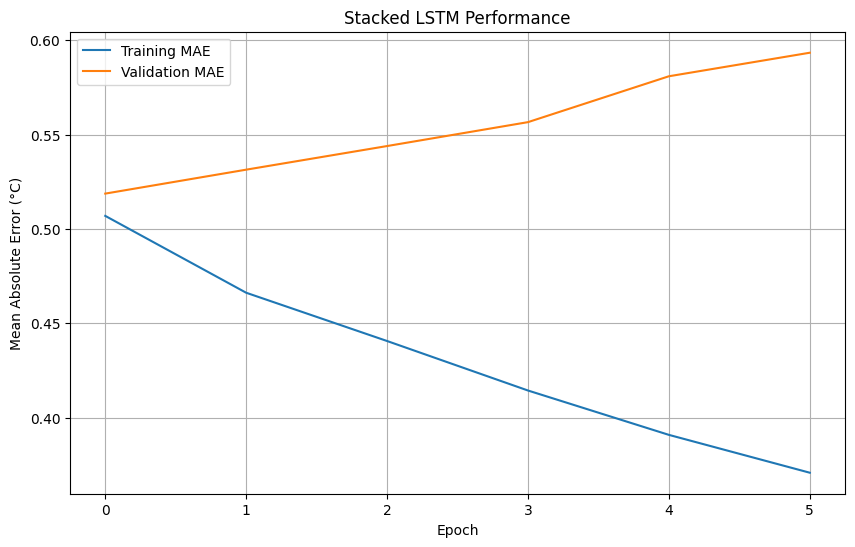

In [26]:
# Import required libraries (even if previously imported)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define variables explicitly to avoid NameError
sequence_length = 120
normalized_data_shape = 14

# Define the stacked LSTM model
def build_stacked_lstm():
    inputs = keras.Input(shape=(sequence_length, normalized_data_shape))
    x = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25)(inputs)
    x = layers.LSTM(32, recurrent_dropout=0.25)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

# Create evaluation function
def evaluate_model(model_name, model_fn):
    print(f"\n===== Training {model_name} =====")

    # Build model
    model = model_fn()
    model.summary()

    # Set up checkpointing and early stopping
    checkpoint_path = f"/content/drive/MyDrive/models/{model_name.lower().replace(' ', '_')}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    ]

    # Train with fewer epochs
    history = model.fit(
        train_dataset,
        epochs=15,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Evaluate on test set
    test_mae = model.evaluate(test_dataset)[1]
    print(f"{model_name} Test MAE: {test_mae:.4f}")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{model_name} Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (°C)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/{model_name.lower().replace(" ", "_")}_performance.png')
    plt.show()

    return history, test_mae

# Now train the stacked LSTM model
hist_stacked, mae_stacked = evaluate_model("Stacked LSTM", build_stacked_lstm)


GRU Model


===== Training GRU Model =====


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 230s 231ms/step - loss: 0.5165 - mae: 0.5493 - val_loss: 0.4483 - val_mae: 0.5130
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 177s 180ms/step - loss: 0.4254 - mae: 0.4962 - val_loss: 0.4363 - val_mae: 0.5035
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 178s 181ms/step - loss: 0.4108 - mae: 0.4870 - val_loss: 0.4313 - val_mae: 0.4988
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 182s 184ms/step - loss: 0.4008 - mae: 0.4802 - val_loss: 0.4268 - val_mae: 0.4942
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 183s 185ms/step - loss: 0.3921 - mae: 0.4736 - val_loss: 0.4262 - val_mae: 0.4922
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 199s 203ms/step - loss: 0.3879 - mae: 0.4711 - val_loss: 0.4261 - val_mae: 0.4912
Epoch 7/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 185s 188ms/step - loss: 0.3826 - mae: 0.4675 - val_loss: 0.4276 - val_mae: 0.4911
Epoch 8/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 183s 185ms/step - loss: 0.3791 - mae: 0.4655 - val_loss: 0.4251 - val_mae: 0.4887
Epoch 9/15
983/983 ━━━━━

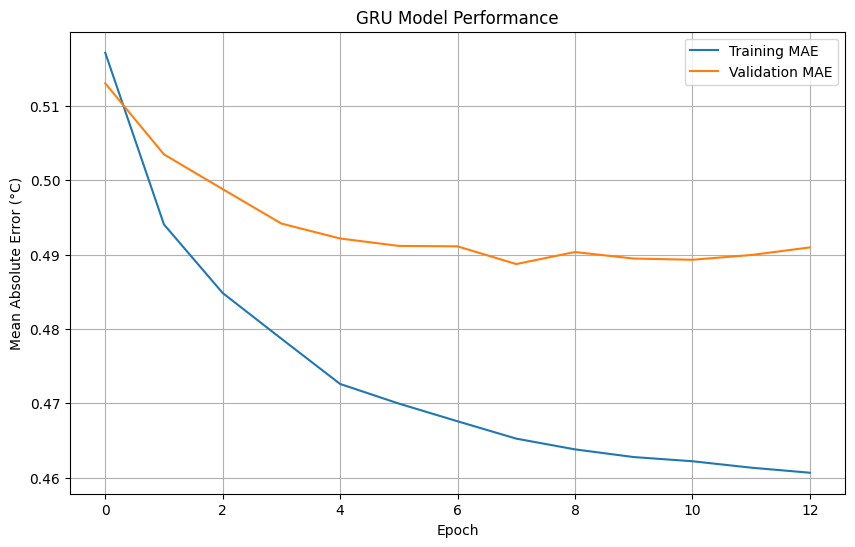

In [28]:
# Import required libraries (even if previously imported)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define variables explicitly to avoid NameError
sequence_length = 120
normalized_data_shape = 14

# Define the GRU model
def build_gru_model():
    inputs = keras.Input(shape=(sequence_length, normalized_data_shape))
    x = layers.GRU(32, recurrent_dropout=0.25)(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

# Create evaluation function
def evaluate_model(model_name, model_fn):
    print(f"\n===== Training {model_name} =====")

    # Build model
    model = model_fn()
    model.summary()

    # Set up checkpointing and early stopping
    checkpoint_path = f"/content/drive/MyDrive/models/{model_name.lower().replace(' ', '_')}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    ]

    # Train with fewer epochs
    history = model.fit(
        train_dataset,
        epochs=15,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Evaluate on test set
    test_mae = model.evaluate(test_dataset)[1]
    print(f"{model_name} Test MAE: {test_mae:.4f}")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{model_name} Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (°C)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/{model_name.lower().replace(" ", "_")}_performance.png')
    plt.show()

    return history, test_mae

# Now train the GRU model
hist_gru, mae_gru = evaluate_model("GRU Model", build_gru_model)


CNN-LSTM Hybrid Model



===== Training CNN-LSTM =====


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 97, 8)               │           2,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 37, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,753 (34.19 KB)

 Trainable params: 8,753 (34.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 191s 190ms/step - loss: 0.5789 - mae: 0.5838 - val_loss: 0.5567 - val_mae: 0.5697
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 135s 137ms/step - loss: 0.4346 - mae: 0.5026 - val_loss: 0.5355 - val_mae: 0.5434
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 133s 135ms/step - loss: 0.3962 - mae: 0.4816 - val_loss: 0.5435 - val_mae: 0.5482
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 131s 133ms/step - loss: 0.3693 - mae: 0.4665 - val_loss: 0.5532 - val_mae: 0.5510
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 131s 133ms/step - loss: 0.3519 - mae: 0.4561 - val_loss: 0.5507 - val_mae: 0.5491
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - loss: 0.3376 - mae: 0.4488 - val_loss: 0.5663 - val_mae: 0.5530
Epoch 7/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 133s 135ms/step - loss: 0.3244 - mae: 0.4407 - val_loss: 0.5716 - val_mae: 0.5555
323/323 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - loss: 0.4014 - mae: 0.4910
CNN-LSTM Test MAE: 0.4901


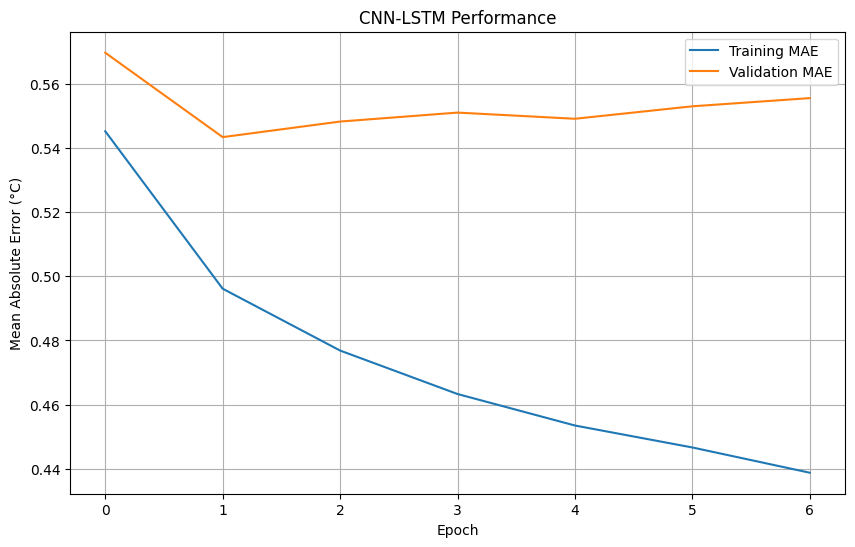

In [29]:
# Import required libraries (even if previously imported)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define variables explicitly to avoid NameError
sequence_length = 120
normalized_data_shape = 14

# Define the CNN-LSTM hybrid model
def build_cnn_lstm():
    inputs = keras.Input(shape=(sequence_length, normalized_data_shape))
    x = layers.Conv1D(8, 24, activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(8, 12, activation="relu")(x)
    x = layers.LSTM(32, recurrent_dropout=0.25)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

# Create evaluation function
def evaluate_model(model_name, model_fn):
    print(f"\n===== Training {model_name} =====")

    # Build model
    model = model_fn()
    model.summary()

    # Set up checkpointing and early stopping
    checkpoint_path = f"/content/drive/MyDrive/models/{model_name.lower().replace(' ', '_')}.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    ]

    # Train with fewer epochs
    history = model.fit(
        train_dataset,
        epochs=15,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    # Evaluate on test set
    test_mae = model.evaluate(test_dataset)[1]
    print(f"{model_name} Test MAE: {test_mae:.4f}")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{model_name} Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (°C)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/{model_name.lower().replace(" ", "_")}_performance.png')
    plt.show()

    return history, test_mae

# Now train the CNN-LSTM hybrid model
hist_cnn_lstm, mae_cnn_lstm = evaluate_model("CNN-LSTM", build_cnn_lstm)


Train and evaluate models


===== Starting Advanced Model Training =====

===== Training Larger LSTM =====


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 298s 300ms/step - loss: 0.4833 - mae: 0.5322 - val_loss: 0.4540 - val_mae: 0.5098
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 322s 300ms/step - loss: 0.3935 - mae: 0.4764 - val_loss: 0.4497 - val_mae: 0.5040
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 322s 301ms/step - loss: 0.3698 - mae: 0.4622 - val_loss: 0.4669 - val_mae: 0.5144
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 296s 300ms/step - loss: 0.3510 - mae: 0.4516 - val_loss: 0.4659 - val_mae: 0.5114
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 325s 304ms/step - loss: 0.3375 - mae: 0.4431 - val_loss: 0.4699 - val_mae: 0.5130
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 297s 302ms/step - loss: 0.3228 - mae: 0.4344 - val_loss: 0.4792 - val_mae: 0.5149
Epoch 7/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 298s 303ms/step - loss: 0.3092 - mae: 0.4269 - val_loss: 0.5106 - val_mae: 0.5278
323/323 ━━━━━━━━━━━━━━━━━━━━ 35s 107ms/step - loss: 0.3409 - mae: 0.4499
Larger LSTM Test MAE: 0.4492


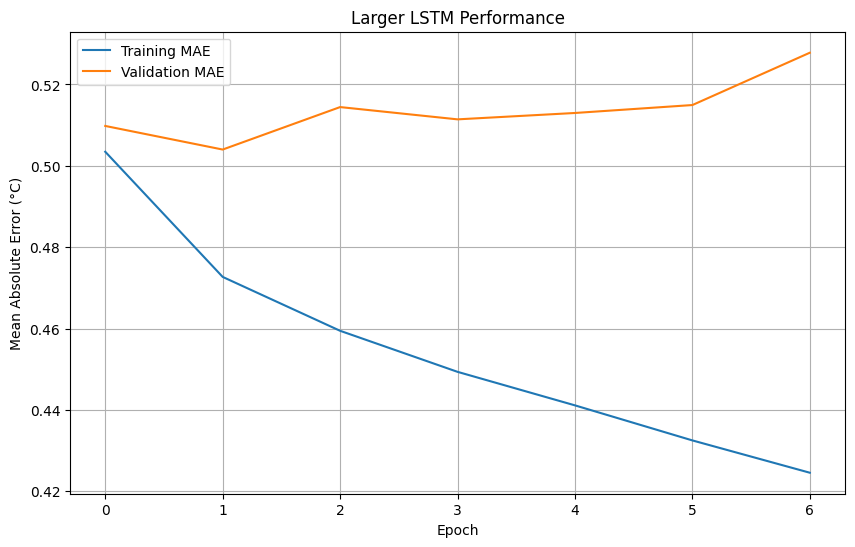


===== Training Stacked LSTM =====


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 120, 64)             │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 537s 539ms/step - loss: 0.4827 - mae: 0.5310 - val_loss: 0.4764 - val_mae: 0.5181
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 522s 498ms/step - loss: 0.3847 - mae: 0.4725 - val_loss: 0.4956 - val_mae: 0.5309
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 539s 536ms/step - loss: 0.3402 - mae: 0.4462 - val_loss: 0.5145 - val_mae: 0.5359
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 496s 504ms/step - loss: 0.3009 - mae: 0.4205 - val_loss: 0.5434 - val_mae: 0.5548
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 505s 508ms/step - loss: 0.2626 - mae: 0.3933 - val_loss: 0.5510 - val_mae: 0.5586
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 504s 509ms/step - loss: 0.2351 - mae: 0.3725 - val_loss: 0.5767 - val_mae: 0.5699
323/323 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - loss: 0.3672 - mae: 0.4687
Stacked LSTM Test MAE: 0.4678


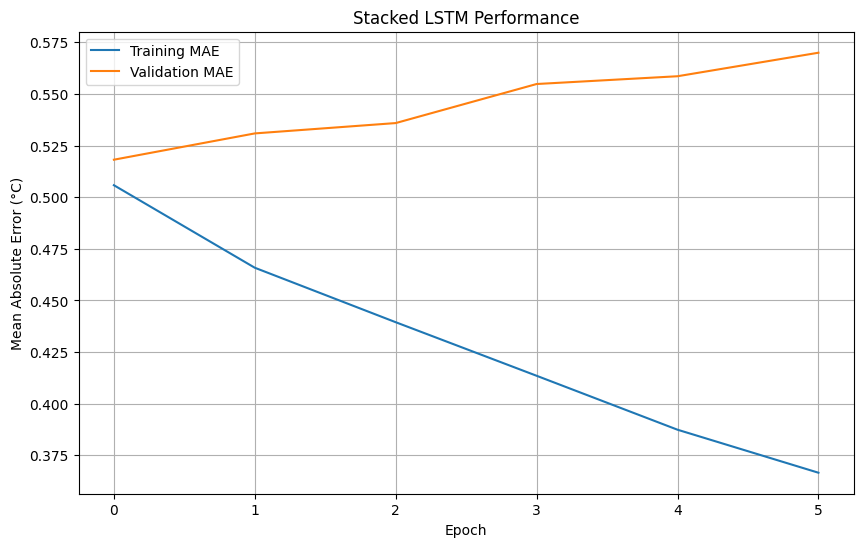


===== Training GRU Model =====


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 198s 198ms/step - loss: 0.6201 - mae: 0.5961 - val_loss: 0.4530 - val_mae: 0.5153
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 175s 178ms/step - loss: 0.4254 - mae: 0.4978 - val_loss: 0.4403 - val_mae: 0.5062
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 203s 179ms/step - loss: 0.4130 - mae: 0.4882 - val_loss: 0.4316 - val_mae: 0.4990
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 201s 178ms/step - loss: 0.4006 - mae: 0.4802 - val_loss: 0.4290 - val_mae: 0.4953
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 201s 177ms/step - loss: 0.3916 - mae: 0.4743 - val_loss: 0.4267 - val_mae: 0.4927
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 175s 178ms/step - loss: 0.3882 - mae: 0.4717 - val_loss: 0.4292 - val_mae: 0.4931
Epoch 7/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 176s 179ms/step - loss: 0.3835 - mae: 0.4691 - val_loss: 0.4305 - val_mae: 0.4932
Epoch 8/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 176s 179ms/step - loss: 0.3811 - mae: 0.4674 - val_loss: 0.4314 - val_mae: 0.4918
Epoch 9/15
983/983 ━━━━━

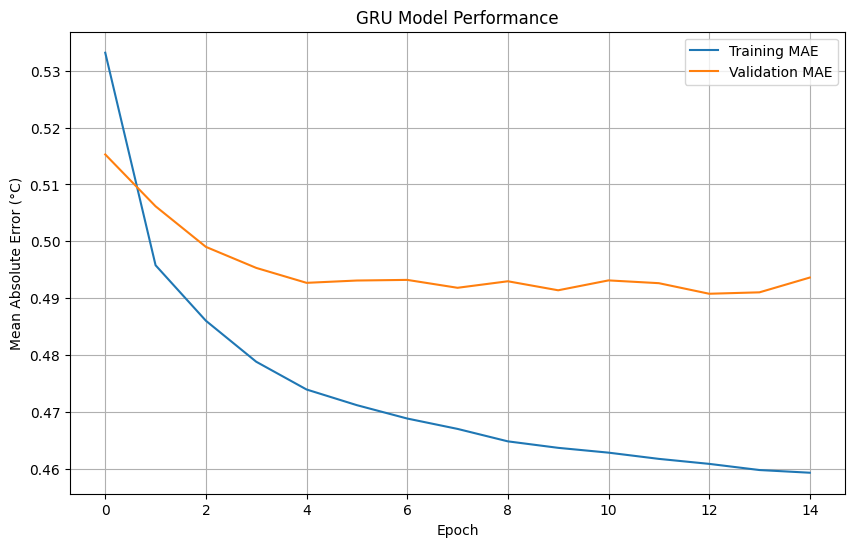


===== Training CNN-LSTM =====


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 120, 14)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 97, 8)               │           2,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 48, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 37, 8)               │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,753 (34.19 KB)

 Trainable params: 8,753 (34.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 148s 144ms/step - loss: 0.5710 - mae: 0.5797 - val_loss: 0.5244 - val_mae: 0.5508
Epoch 2/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 142s 144ms/step - loss: 0.4253 - mae: 0.4969 - val_loss: 0.5039 - val_mae: 0.5380
Epoch 3/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - loss: 0.3939 - mae: 0.4791 - val_loss: 0.5057 - val_mae: 0.5359
Epoch 4/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 145s 146ms/step - loss: 0.3781 - mae: 0.4703 - val_loss: 0.5107 - val_mae: 0.5385
Epoch 5/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 138s 140ms/step - loss: 0.3639 - mae: 0.4617 - val_loss: 0.5215 - val_mae: 0.5365
Epoch 6/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 136s 138ms/step - loss: 0.3537 - mae: 0.4558 - val_loss: 0.5344 - val_mae: 0.5406
Epoch 7/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 141s 143ms/step - loss: 0.3444 - mae: 0.4496 - val_loss: 0.5640 - val_mae: 0.5537
Epoch 8/15
983/983 ━━━━━━━━━━━━━━━━━━━━ 139s 141ms/step - loss: 0.3342 - mae: 0.4442 - val_loss: 0.5790 - val_mae: 0.5570
323/323 ━━━━━━━━━━━━━━━━

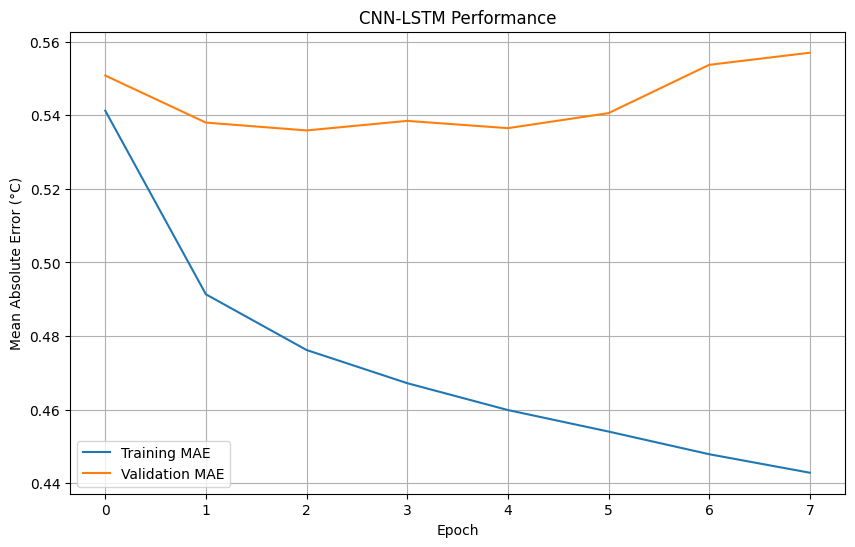

In [30]:
# Initialize results dictionary with baseline result
results = {
    "Baseline LSTM": 0.4572  # Your baseline result
}

# Train models one by one
print("\n===== Starting Advanced Model Training =====")

# 1. Train Larger LSTM
hist_larger, mae_larger = evaluate_model("Larger LSTM", build_larger_lstm)
results["Larger LSTM"] = mae_larger

# 2. Train Stacked LSTM
hist_stacked, mae_stacked = evaluate_model("Stacked LSTM", build_stacked_lstm)
results["Stacked LSTM"] = mae_stacked

# 3. Train GRU Model
hist_gru, mae_gru = evaluate_model("GRU Model", build_gru_model)
results["GRU Model"] = mae_gru

# 4. Train CNN-LSTM
hist_cnn_lstm, mae_cnn_lstm = evaluate_model("CNN-LSTM", build_cnn_lstm)
results["CNN-LSTM"] = mae_cnn_lstm
